In [32]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os
from PIL import Image
import json
import torch
import pathlib
from pathlib import Path
import PixelEncoder
from typing import Tuple, Dict, List
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import math
from math import sqrt
from tqdm.auto import tqdm
import PixelEncoder
from PixelEncoder import PixelEncodingSet, Segments

/opt/homebrew/Caskroom/miniforge/base/envs/sketch_simplification/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:

data_path = Path(
    f"/Users/mary/Documents/School/Sketch Simplification/Sketch-Simplification/dataset"
)
device = "cpu"

In [19]:
class SketchData(torch.utils.data.Dataset):
    """
    Custom PyTorch dataset for image and JSON pairs.

    Args:
        root_dir (str): Path to the root directory containing image folders.
        transform (callable, optional): A function/transform to apply to the image.
    """

    def __init__(self, targ_dir, transform=None):
        self.paths = list(targ_dir.glob("*/."))

        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index: int):
        "Returns one sample of data, data and label (X, y)."

        data_path = self.paths[index]

        img = Image.open(data_path / Path("base.png"))

        if self.transform:
            # return data, label (X, y)
            return self.transform(img), index
        else:
            return img, index

    def getOtherData(self, index: int):
        data_path = self.paths[index]
        pixe_set = PixelEncodingSet.load(data_path / Path("pixe_set.json"))
        segs = Segments.load(data_path / Path("segs.json"), fromBlender=False)
        return pixe_set, segs


data = SketchData(targ_dir=data_path)
data.getOtherData(0)

(<PixelEncoder.PixelEncodingSet at 0x293105420>,
 <PixelEncoder.Segments at 0x293428250>)

In [20]:
# Global params


T = 10

BATCH_SIZE = 1

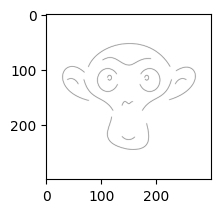

In [21]:
def show_images(data, num_samples=20, cols=4):
    """Plots some samples from the dataset"""
    plt.figure(figsize=(15, 15))
    for i, img_data in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples / cols) + 1, cols, i + 1)
        plt.imshow(img_data[0])


show_images(data)

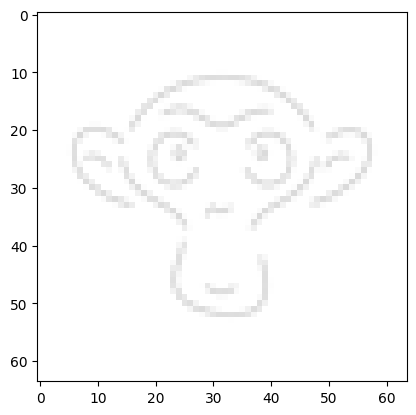

In [61]:
# Transform data

IMG_SIZE = 10, 10


def load_transformed_dataset():

    data_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )
    train = SketchData(data_path, transform=data_transforms)

    # TODO make data split so that we aren't using duplicate data
    test = SketchData(data_path, transform=data_transforms)
    return train


def show_tensor_image(image):
    reverse_transforms = transforms.Compose(
        [
            transforms.ToPILImage(),
        ]
    )

    plt.imshow(reverse_transforms(image))


data = load_transformed_dataset()
show_tensor_image(data[0][0])

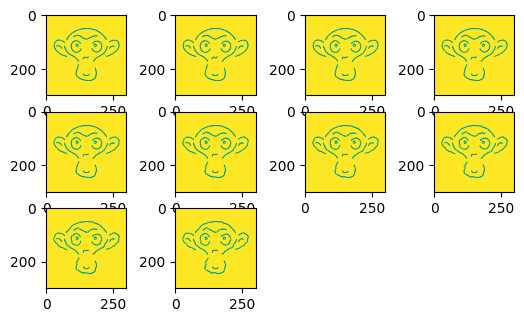

In [38]:
def forward_diffusion_sample(img0_data, t, device="cpu"):
    img0, img_index = img0_data
    pixe_set, segs = data.getOtherData(img_index)

    segs1 = PixelEncoder.generateSketchSegs(segs, t)

    return pixe_set.img(segs1), 0


num_images = 1

# print(data[0])
dataloader = DataLoader(data, batch_size=BATCH_SIZE,
                        shuffle=True, drop_last=False)


image_data = next(iter(dataloader))

for idx in range(0, T):
    t = torch.Tensor([idx]).type(torch.int64)

    plt.subplot(int(sqrt(T)) + 1, int(sqrt(T)) + 1, idx + 1)
    # plt.axis(False)
    img, noise = forward_diffusion_sample(image_data, idx / T)
    plt.imshow(img)

plt.show()

In [51]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(
        self,
        x,
        t,
    ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(...,) + (None,) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(
            half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """

    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
        )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList(
            [
                Block(down_channels[i], down_channels[i + 1], time_emb_dim)
                for i in range(len(down_channels) - 1)
            ]
        )
        # Upsample
        self.ups = nn.ModuleList(
            [
                Block(up_channels[i], up_channels[i + 1],
                      time_emb_dim, up=True)
                for i in range(len(up_channels) - 1)
            ]
        )

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)


model = SimpleUnet()
model.to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  62437601


In [60]:
img, img_index = data[0]

print("mode = ", img[0].mode)

# show_tensor_image(img[0])
t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
model(img, t)

mode =  <built-in method mode of Tensor object at 0x291474ae0>


RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[1, 4, 300, 300] to have 1 channels, but got 4 channels instead

In [30]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [33]:
epochs = 3
# tqdm is for showing the progress bar
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")

    # training

    train_loss = 0
    # add a loop to loop through all the batches
    for batch, (img, index) in enumerate(dataloader):
        model.train()

        preds = model(X)
        loss = loss_fn(preds, y)
        train_loss += (
            loss  # for getting average loss per batch in all batches in this epoch
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            # len(train_dataloader.dataset) is the total number of samples in our dataset
            print(f"looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

        train_loss /= len(train_dataloader)  # get average loss for the batch

    # calculate test data
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0(X_test)
            test_loss += loss_fn(test_pred, y_test)

            # test_pred.argmax gives the highest
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    # print stats for epoch
    print(
        f"Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc}"
    )
    end_time = timer()
    total_train_time_model_0 = print_train_time(
        start=start_time, end=end_time, device=getModelDevice(model_0)
    )

NameError: name 'epochs' is not defined